In [37]:
import projectq
from projectq.ops import All, Measure, QubitOperator, TimeEvolution, X
from projectq.ops import CNOT, H, Rz, Rx, Ry, X, Z, Y
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar
from scipy.optimize import minimize_scalar,minimize
import numpy as np
from numpy.linalg import norm
import pickle

In [2]:
raw_data = np.loadtxt("hamiltonians.txt")
coeff_hams= raw_data[:50,1:]
bond_distances=raw_data[:50,0]
n_samples,n_features=coeff_hams.shape[0],coeff_hams.shape[1]

def ham(config_Hs,i):
    #bond_distances.append(config_H[i,0])
    config_H=config_Hs[i,:]
    hamiltonian = config_H[0] * QubitOperator(())  # == identity
    hamiltonian += config_H[1] * QubitOperator("Z0")
    hamiltonian += config_H[2] * QubitOperator("Z1")
    hamiltonian += config_H[3] * QubitOperator("Z0 Z1")
    hamiltonian += config_H[4] * QubitOperator("X0 X1")
    hamiltonian += config_H[5] * QubitOperator("Y0 Y1")
    #return energies/thetas.shape[0] 
    return hamiltonian

hams=[ham(coeff_hams,i) for i in range(n_samples)]

In [3]:
def loss_H(theta,ham):
    # Create a ProjectQ compiler with a simulator as a backend

    eng = projectq.MainEngine()
    # Allocate 2 qubits in state |00>
    wf= eng.allocate_qureg(2)
    # Initialize the Hartree Fock state |01>
    X | wf[0]
    ansatz_op1 = QubitOperator('X0 Y1')
    ansatz_op2 = 2*QubitOperator('X0')+1.5*QubitOperator('X1')
    # Apply the unitary e^{-i * ansatz_op * t}
    TimeEvolution(-theta[0]/2, ansatz_op1) | wf 
    TimeEvolution(theta[1], ansatz_op2) | wf
    eng.flush()
    energy = eng.backend.get_expectation_value(ham, wf)
    All(Measure) | wf
    return energy

def energies(thetas,hams):
    es=[]
    for i in range(thetas.shape[0]):
        es.append(loss_H(thetas[i],hams[i]))
    return np.array(es)

In [4]:
def grad(theta,ham):
    d=0.005
    d1=np.array([d,0])
    d2=np.array([0,d])
    g1 = (loss_H(theta+d1,ham)-loss_H(theta-d1,ham))/(2*d)
    g2 =(loss_H(theta+d2,ham)-loss_H(theta-d2,ham))/(2*d)
   # g3 =(loss_H(theta+d3,ham)-loss_H(theta-d3,ham))/(2*d)
    return np.array([g1,0.2*g2])

def grads(thetas,hams,bc='OBC'):
    gs=[]
    for i in range(thetas.shape[0]):
        gs.append(grad(thetas[i],hams[i]).tolist())
    gs=np.array(gs)
    #if bc == 'OBC':
        #gs[0]=gs[-1]=0
        #gs[0]=0
    return gs

In [5]:
def alpha_term(length,less1,less2,more1,more2,bc = 'OBC'):
        """The arc-length force."""

        res = np.zeros((length, length))
        range_ = range(1, length - 1) if bc == 'OBC' else range(length)
        for i in range_:
            res[i, i] += 2.
            res[i, less1[i]] += -1.
            res[i, more1[i]] += -1.
        return res

def beta_term(length,less1,less2,more1,more2,bc = 'OBC'):
    """The arc-bending force."""

    res = np.zeros((length, length))
    range_ = range(1, length - 1) if bc == 'OBC' else range(length)
    for i in range_:
        res[i, i] += 6.
        # nn
        res[i, less1[i]] += -4.
        res[i, more1[i]] += -4.
        # nnn left
        if bc == 'OBC' and i == 1:
            # mirror-point method
            res[1, 0] += 2.
            res[1, 1] -= 1.
        else:
            res[i, less2[i]] += +1.
        # nnn right
        if bc == 'OBC' and i == length - 2:
            # mirror-point method
            res[length - 2, length - 1] += 2.
            res[length - 2, length - 2] -= 1.
        else:
            res[i, more2[i]] += +1.
    return res

def snake_matrix(alpha,beta,gamma,bc='OBC'):
    id_ = np.arange(n_samples)
    less1 = np.roll(id_, +1)
    less2 = np.roll(id_, +2)
    more1 = np.roll(id_, -1)
    more2 = np.roll(id_, -2)
    length=n_samples
    # implicit time-evolution matrix as in Kass
    A = alpha * alpha_term(length,less1,less2,more1,more2,bc = bc) + beta * beta_term(length,less1,less2,more1,more2,bc = bc)
    inversion_A = np.linalg.inv(A + gamma * np.identity(length))
    #return np.linalg.inv(inversion_A)
    return inversion_A

In [6]:
def training(hams,decay_rate=0.05,learning_rate=1,snake_paras=[0.5,3,4],t_steps=30,stop_e=1e-4):
    thetas=2*(np.random.rand(n_samples,2)-0.5)
    gamma=snake_paras[2]
    thetas_history=[thetas]     
    for i in range(t_steps+1):    
        decay=np.exp(-i*decay_rate)
        alpha=snake_paras[0]*decay
        beta=snake_paras[1]*decay
        inv_A=snake_matrix(alpha,beta,gamma)
        thetas=np.dot(inv_A, gamma*thetas-learning_rate*grads(thetas,hams))
        #thetas=np.clip(thetas,0,2*np.pi)
        #thetas=reshape(thetas,n_samples,bc='OBC')
        if i%5==0:
            thetas_history.append(thetas)
            print(thetas[[0,10,15,-1]])
    return thetas_history

In [7]:
theta_history=training(hams,t_steps=100)

[[ 0.17006323  0.05830298]
 [ 0.13272617  0.07670296]
 [ 0.34577632  0.09411899]
 [-0.68164547  0.42371339]]
[[ 8.35031102e-02 -1.46150636e-02]
 [ 2.53203233e-01 -8.93163488e-05]
 [ 3.32357422e-01 -9.25309753e-04]
 [-2.05455975e-01  2.29882644e-01]]
[[ 7.85936113e-02  4.78156993e-03]
 [ 2.24821818e-01  9.63779605e-07]
 [ 3.23662147e-01 -2.22849019e-06]
 [ 2.07132485e-01  4.81618674e-02]]
[[ 7.82472840e-02 -1.58871284e-03]
 [ 2.15122291e-01 -1.91127442e-07]
 [ 3.23255871e-01 -4.41964721e-09]
 [ 5.30234894e-01  1.30523627e-02]]
[[7.82150807e-02 5.28553284e-04]
 [2.11815892e-01 2.74987798e-08]
 [3.24284638e-01 2.44656510e-09]
 [7.87168785e-01 5.35887664e-03]]
[[ 7.82116990e-02 -1.75869242e-04]
 [ 2.10646412e-01 -2.43590090e-09]
 [ 3.25169285e-01  5.56204966e-10]
 [ 9.78727884e-01  2.90182623e-03]]
[[ 7.82113300e-02  5.85190478e-05]
 [ 2.10206801e-01 -1.25570208e-10]
 [ 3.25691726e-01  1.37607200e-10]
 [ 1.11574921e+00  1.86042719e-03]]
[[ 7.82112893e-02 -1.94717639e-05]
 [ 2.10023767e-01 

In [243]:
import pickle
with open("theta_history.txt",'wb') as fp:
    pickle.dump(theta_history,fp)

In [34]:
snake_energies=energies(theta_history[-1],hams)

In [53]:
theta_history[-1][3][1]

-2.1631551593477064e-14

Compare with normal VQE

In [38]:
VQE_energies = []
VQE_thetas=[]
for i in range(len(hams)):
    
    # Use Scipy to perform the classical outerloop of the variational
    # eigensolver, i.e., the minimization of the parameter theta.
    
    # See documentation of Scipy for different optimizers.
    minimum = minimize(lambda theta: loss_H(theta,hams[i]), [0.5,0.5],method='nelder-mead',
               options={'xtol': 1e-8})
    VQE_energies.append(minimum.fun)
    VQE_thetas.append(minimum.x)
    if (i+1)%10 == 0:
        print("i=",i,"\t theta=",minimum.x)
        
    
# np.savetxt("VQE_energies.txt",np.array(VQE_energies))

i= 9 	 theta= [ 1.91314046e-01 -9.19155683e-10]
i= 19 	 theta= [ 4.50374051e-01 -1.58052927e-09]
i= 29 	 theta= [8.58634681e-01 1.53189194e-09]
i= 39 	 theta= [1.2239814e+00 1.3881169e-09]
i= 49 	 theta= [1.42336588e+00 3.99385270e-09]


In [42]:
(energies_vqe - VQE_energies).sum()

3.83026943495679e-15

In [54]:
(energies_vqe - snake_energies).sum()

-1.8228326676694717e-06

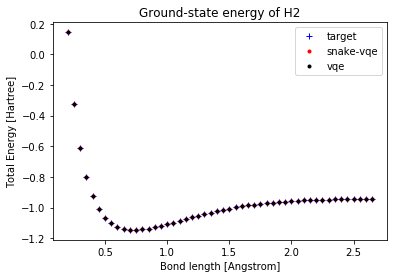

In [45]:
energies_vqe=np.loadtxt("gs_energy.txt")[:50]

plt.xlabel("Bond length [Angstrom]")
plt.ylabel("Total Energy [Hartree]")
plt.title("Ground-state energy of H2")
plt.plot(bond_distances, energies_vqe, "b+",
         label="target")
plt.plot(bond_distances, snake_energies, "r.",
         label="snake-vqe")
plt.plot(bond_distances, VQE_energies, "k.",
        label="vqe")
plt.legend()
plt.show()

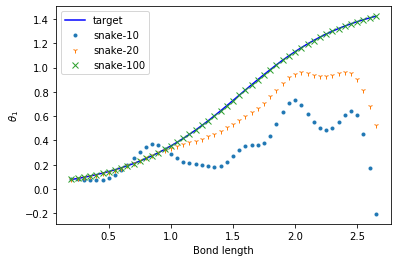

In [110]:
thetas=np.loadtxt("thetas.txt")[:50]
bond_distance=bond_distances
plt.xlabel("Bond length")
plt.ylabel("$\\theta_1$")
#plt.title("An evolving snake for VQE")
plt.plot(bond_distance, thetas, "b-",
         label="target")
# plt.plot(bond_distance, theta_history[0][:,0], 
#          '+',label="snake-ini")
plt.plot(bond_distance, theta_history[2][:,0], 
         '.',label="snake-10")
plt.plot(bond_distance, theta_history[4][:,0], 
         '1',label="snake-20")
plt.plot(bond_distance, theta_history[-1][:,0], 
         'x',label="snake-100")
plt.legend()
plt.savefig("snake_theta1.jpg",dpi=300)


plt.show()

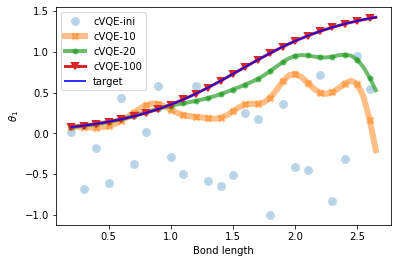

In [347]:

plt.xlabel("Bond length")
plt.ylabel("$\\theta_1$")
#plt.title("An evolving snake for VQE")

plt.plot(bond_distance, theta_history[0][:,0], 
         'C0.',mew ='6',alpha=0.3,markevery=2,label="cVQE-ini")
plt.plot(bond_distance, theta_history[2][:,0], 
         'C1x-',mew=3,lw ='6',alpha=0.5,markevery=2,label="cVQE-10")
# plt.plot(bond_distance, theta_history[3][:,0], 
#          'b-',lw ='5',alpha=0.5,label="snake-20")
plt.plot(bond_distance, theta_history[4][:,0], 
         'C2.-',mew=3,lw ='4',alpha=0.7,markevery=2,label="cVQE-20")
plt.plot(bond_distance, theta_history[-1][:,0], 
         'C3v-',mew=2,lw ='3',alpha=1.0,markevery=2,label="cVQE-100")
plt.plot(bond_distance, thetas, "b-",lw ='2',alpha=0.8,label='target')
plt.legend()
plt.savefig("snake_theta1.jpg",dpi=300)
plt.show()

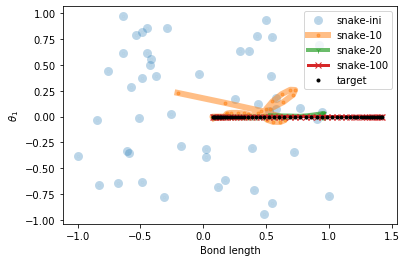

In [342]:

plt.xlabel("Bond length")
plt.ylabel("$\\theta_1$")
#plt.title("An evolving snake for VQE")

plt.plot(theta_history[0][:,0], theta_history[0][:,1], 
         '.',mew ='6',alpha=0.3,label="snake-ini")
plt.plot(theta_history[2][:,0], theta_history[2][:,1], 
         '.-',lw ='6',alpha=0.5,label="snake-10")
plt.plot(theta_history[4][:,0], theta_history[4][:,1], 
         '1-',lw ='4',alpha=0.7,label="snake-20")
plt.plot(theta_history[-1][:,0], theta_history[-1][:,1], 
         'x-',lw ='3',alpha=1.0,label="snake-100")
plt.plot(theta_history[-1][:,0], theta_history[-1][:,1], "k.",markevery=1,
         label="target")
plt.legend()

plt.show()

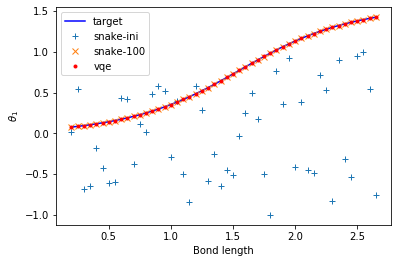

In [68]:
thetas=np.loadtxt("thetas.txt")[:50]
bond_distance=bond_distances
plt.xlabel("Bond length")
plt.ylabel("$\\theta_1$")
#plt.title("An evolving snake for VQE")
plt.plot(bond_distance, thetas, "b-",
         label="target")
plt.plot(bond_distance, theta_history[0][:,0], 
         '+',label="snake-ini")
plt.plot(bond_distance, theta_history[-1][:,0], 
         'x',label="snake-100")
plt.plot(bond_distance, np.array(VQE_thetas)[:,0], 
         'r.',label="vqe")
plt.legend()


plt.show()

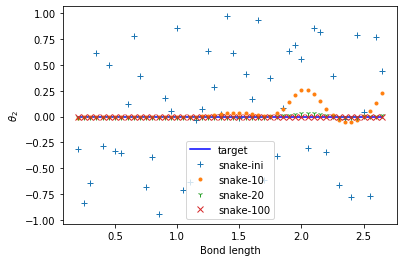

In [343]:
thetas=np.loadtxt("thetas.txt")[:50]
bond_distance=bond_distances
plt.xlabel("Bond length")
plt.ylabel("$\\theta_2$")
#plt.title("An evolving snake for VQE")
plt.plot(bond_distance, np.zeros(50), "b-",
         label="target")
plt.plot(bond_distance, theta_history[0][:,1], 
         '+',label="snake-ini")
plt.plot(bond_distance, theta_history[2][:,1], 
         '.',label="snake-10")
plt.plot(bond_distance, theta_history[4][:,1], 
         '1',label="snake-20")
plt.plot(bond_distance, theta_history[-1][:,1], 
         'x',label="snake-100")
plt.legend()
plt.savefig("snake_theta2.jpg",dpi=300)

plt.show()

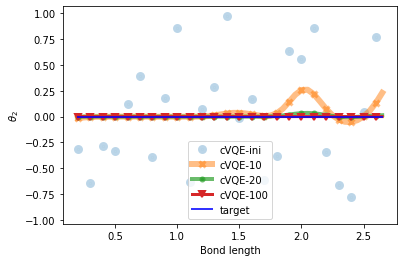

In [348]:
thetas=np.loadtxt("thetas.txt")[:50]
bond_distance=bond_distances
plt.xlabel("Bond length")
plt.ylabel("$\\theta_2$")
#plt.title("An evolving snake for VQE")

plt.plot(bond_distance, theta_history[0][:,1], 
         'C0.',mew ='6',alpha=0.3,markevery=2,label="cVQE-ini")
plt.plot(bond_distance, theta_history[2][:,1], 
         'C1x-',mew=3,lw ='6',alpha=0.5,markevery=2,label="cVQE-10")
plt.plot(bond_distance, theta_history[4][:,1], 
         'C2.-',mew=3,lw ='4',alpha=0.7,markevery=2,label="cVQE-20")
plt.plot(bond_distance, theta_history[-1][:,1], 
         'C3v-',mew=2,lw ='3',alpha=1.0,markevery=2,label="cVQE-100")

plt.plot(bond_distance, np.zeros(50), "b-",lw ='2',alpha=0.8,
         label="target")
plt.legend()
plt.savefig("snake_theta2.jpg",dpi=300)

plt.show()



In [13]:
def training_decoupled(hams,learning_rate=0.25,t_steps=30,stop_e=1e-4):
    thetas=2*(np.random.rand(n_samples,2)-0.5)
    thetas_history=[thetas]
    for i in range(t_steps+1):     
        thetas=thetas-learning_rate*grads(thetas,hams)
        #thetas=np.clip(thetas,0,2*np.pi)
        #thetas=reshape(thetas,n_samples,bc='OBC')
        if i%5==0:
            thetas_history.append(thetas)
            print(thetas[[0,10,15,-1]])
    return thetas_history

In [253]:
def training_decoupled(hams,learning_rate=0.25,t_steps=30,stop_e=1e-4):
    
    with open('theta_history.txt', 'rb') as fp:
        temp_thetas = pickle.load(fp)
    thetas = temp_thetas[0]
    
#     thetas=2*(np.random.rand(n_samples,2)-0.5)
    thetas_history=[thetas]
    for i in range(t_steps+1):     
        thetas=thetas-learning_rate*grads(thetas,hams)
        #thetas=np.clip(thetas,0,2*np.pi)
        #thetas=reshape(thetas,n_samples,bc='OBC')
        if i%5==0:
            thetas_history.append(thetas)
            print(thetas[[0,10,15,-1]])
    return thetas_history



In [254]:
theta_history_nosnake=training_decoupled(hams,t_steps=100)

[[ 0.17006323  0.05830298]
 [-0.21047153  0.21710022]
 [ 0.49358857  0.02133078]
 [-0.68164547  0.42371339]]
[[ 8.35031102e-02 -1.46150636e-02]
 [ 9.92597141e-02  2.70524292e-06]
 [ 4.00299141e-01  1.15833574e-04]
 [-2.05455975e-01  2.29882644e-01]]
[[ 7.85936113e-02  4.78156993e-03]
 [ 1.76790361e-01 -1.57540647e-13]
 [ 3.58656128e-01  3.27718015e-07]
 [ 2.07132485e-01  4.81618674e-02]]
[[ 7.82472840e-02 -1.58871284e-03]
 [ 1.99916091e-01  1.11022302e-16]
 [ 3.40324330e-01  6.77714107e-10]
 [ 5.30234894e-01  1.30523627e-02]]
[[7.82150807e-02 5.28553284e-04]
 [2.06802475e-01 1.11022302e-16]
 [3.32259476e-01 1.21413990e-12]
 [7.87168785e-01 5.35887664e-03]]
[[ 7.82116990e-02 -1.75869242e-04]
 [ 2.08852798e-01  1.11022302e-16]
 [ 3.28711870e-01  1.77635684e-15]
 [ 9.78727884e-01  2.90182623e-03]]
[[ 7.82113300e-02  5.85190478e-05]
 [ 2.09463245e-01 -9.99200722e-16]
 [ 3.27151368e-01 -4.44089210e-16]
 [ 1.11574921e+00  1.86042719e-03]]
[[ 7.82112893e-02 -1.94717639e-05]
 [ 2.09644994e-01 

In [255]:
with open("theta_history_nosnake.txt",'wb') as fp:
    pickle.dump(theta_history_nosnake,fp)

In [276]:
t_history = np.array(theta_history_nosnake)
t_history.shape

(22, 50, 2)

In [296]:
t_history[:,2,:]

array([[-0.67817816, -0.64708874],
       [-0.72908232, -0.63857901],
       [-1.29584703, -0.82805296],
       [-2.81301756, -0.90889021],
       [-3.1215198 , -0.90707252],
       [-3.15117176, -0.90700933],
       [-3.15396567, -0.90698269],
       [-3.15422901, -0.90698123],
       [-3.15425383, -0.90698104],
       [-3.15425617, -0.90698102],
       [-3.15425639, -0.90698102],
       [-3.15425641, -0.90698102],
       [-3.15425641, -0.90698102],
       [-3.15425641, -0.90698102],
       [-3.15425641, -0.90698102],
       [-3.15425641, -0.90698102],
       [-3.15425641, -0.90698102],
       [-3.15425641, -0.90698102],
       [-3.15425641, -0.90698102],
       [-3.15425641, -0.90698102],
       [-3.15425641, -0.90698102],
       [-3.15425641, -0.90698102]])

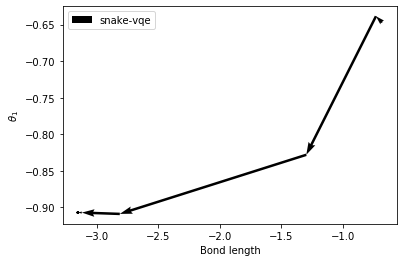

In [328]:
t_history[:,2,:];

plt.xlabel("Bond length")
plt.ylabel("$\\theta_1$")
#plt.title("Evolving parameters for VQE")

x = t_history[:,2,0]
y = t_history[:,2,1]
u = np.array([x[i+1]-x[i] for i in range(len(x)-1)])
v = np.array([y[i+1]-y[i] for i in range(len(x)-1)])

x = x[:len(u)] # 使得维数和u,v一致
y = y[:len(v)]

# c = np.random.randn(len(u)) # arrow颜色

plt.quiver(x,y,u,v,angles='xy', scale_units='xy', scale=1, label="snake-vqe") # 注意参数的赋值

# plt.plot(t_history[:,2,0], t_history[:,2,1], 
#          'o-',mew ='1',ms='10',markevery=1,alpha=0.8,label="step-100")
# markevery=5,
plt.legend()
plt.show()

In [292]:
u

array([-5.09041611e-02, -5.66764712e-01, -1.51717053e+00, -3.08502241e-01,
       -2.96519558e-02, -2.79390815e-03, -2.63344078e-04, -2.48168492e-05,
       -2.33896560e-06, -2.20430416e-07, -2.07747082e-08, -1.95792937e-09,
       -1.84535942e-10, -1.73971948e-11, -1.62003744e-12, -1.54098956e-13,
       -1.15463195e-14,  3.99680289e-15, -2.22044605e-14,  1.50990331e-14,
       -2.93098879e-14])

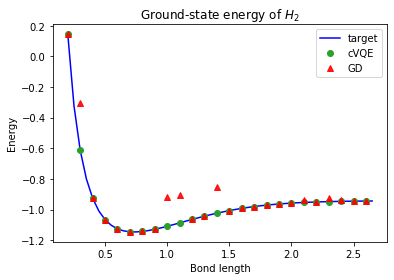

In [398]:
snake_energies_nosnake=energies(theta_history_nosnake[-1],hams)
plt.xlabel("Bond length")
plt.ylabel("Energy")
plt.title("Ground-state energy of $H_2$")
plt.plot(bond_distances, energies_vqe, "b-",
         label="target")
plt.plot(bond_distances, snake_energies, "C2o",ms=6,markevery=2,
         label="cVQE")
plt.plot(bond_distances, snake_energies_nosnake, "r^",ms=6,alpha=0.9,markevery=2,
         label="GD")
#plt.plot(bond_distances, energies_vqe, "r+",
#         label="vqe")
plt.legend()
plt.savefig("GS_H2.jpg",dpi=300)
plt.show()

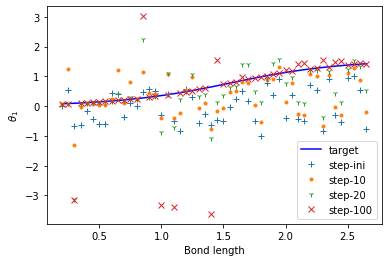

In [260]:
thetas=np.loadtxt("thetas.txt")[:50]
bond_distance=bond_distances
plt.xlabel("Bond length")
plt.ylabel("$\\theta_1$")
#plt.title("Evolving parameters for VQE")
plt.plot(bond_distance, thetas, "b-",
         label="target")
plt.plot(bond_distance, theta_history_nosnake[0][:,0], 
         '+',label="step-ini")
plt.plot(bond_distance, theta_history_nosnake[2][:,0], 
         '.',label="step-10")
plt.plot(bond_distance, theta_history_nosnake[4][:,0], 
         '1',label="step-20")
plt.plot(bond_distance, theta_history_nosnake[-1][:,0], 
         'x',label="step-100")
plt.legend()
plt.savefig("no_snake_theta1.jpg",dpi=300)
plt.show()

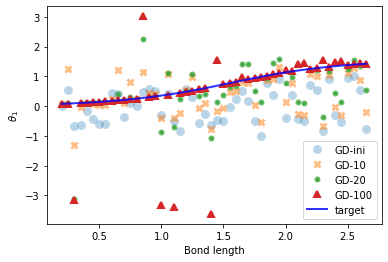

In [399]:


plt.xlabel("Bond length")
plt.ylabel("$\\theta_1$")
#plt.title("Evolving parameters for VQE")

plt.plot(bond_distance, theta_history_nosnake[0][:,0], 
         'C0.',mew ='6',alpha=0.3,markevery=1,label="GD-ini")
plt.plot(bond_distance, theta_history_nosnake[2][:,0], 
         'C1x',mew=3,lw ='6',alpha=0.5,markevery=1,label="GD-10")
# plt.plot(bond_distance, theta_history[3][:,0], 
#          'b-',lw ='5',alpha=0.5,label="snake-20")
plt.plot(bond_distance, theta_history_nosnake[4][:,0], 
         'C2.',mew=3,lw ='4',alpha=0.7,markevery=1,label="GD-20")
plt.plot(bond_distance, theta_history_nosnake[-1][:,0], 
         'C3^',mew=2,lw ='3',alpha=1.0,markevery=1,label="GD-100")
plt.plot(bond_distance, thetas, "b-",lw ='2',alpha=0.8,label='target')


# plt.plot(bond_distance, thetas, "b-",
#          label="target")
# plt.plot(bond_distance, theta_history_nosnake[0][:,0], 
#          '+',lw ='3',alpha=0.3,label="step-ini")
# plt.plot(bond_distance, theta_history_nosnake[2][:,0], 
#          '.',lw ='3',alpha=0.4,label="step-10")
# plt.plot(bond_distance, theta_history_nosnake[4][:,0], 
#          '1',lw ='3',alpha=0.6,label="step-20")
# plt.plot(bond_distance, (theta_history_nosnake[-1][:,0] + np.pi/2)%np.pi-np.pi/2, 
#          'o',mew ='0',ms='10',markevery=1,alpha=0.8,label="step-100")
# markevery=5,

plt.legend()
plt.savefig("no_snake_theta1.jpg",dpi=300)
plt.show()

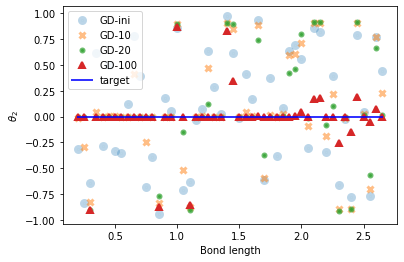

In [400]:
thetas=np.loadtxt("thetas.txt")[:50]
bond_distance=bond_distances
plt.xlabel("Bond length")
plt.ylabel("$\\theta_2$")
#plt.title("Evolving parameters for VQE")
#plt.plot(bond_distance, thetas, "b-",
#         label="true")

plt.plot(bond_distance, theta_history_nosnake[0][:,1], 
         'C0.',mew ='6',alpha=0.3,markevery=1,label="GD-ini")
plt.plot(bond_distance, theta_history_nosnake[2][:,1], 
         'C1x',mew=3,lw ='6',alpha=0.5,markevery=1,label="GD-10")
# plt.plot(bond_distance, theta_history[3][:,0], 
#          'b-',lw ='5',alpha=0.5,label="snake-20")
plt.plot(bond_distance, theta_history_nosnake[4][:,1], 
         'C2.',mew=3,lw ='4',alpha=0.7,markevery=1,label="GD-20")
plt.plot(bond_distance, theta_history_nosnake[-1][:,1], 
         'C3^',mew=2,lw ='3',alpha=1.0,markevery=1,label="GD-100")
plt.plot(bond_distance, np.zeros(50), "b-",lw ='2',alpha=0.8,
         label="target")
plt.legend()
plt.savefig("no_snake_theta2.jpg",dpi=300)
plt.show()

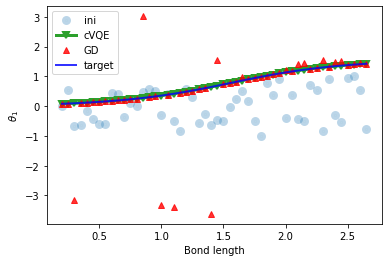

In [402]:

plt.xlabel("Bond length")
plt.ylabel("$\\theta_1$")
#plt.title("An evolving snake for VQE")

plt.plot(bond_distance, theta_history[0][:,0], 
         'C0.',mew ='6',alpha=0.3,markevery=1,label="ini")

plt.plot(bond_distance, theta_history[-1][:,0], 
         'C2v-',mew=2,lw ='3',alpha=1.0,markevery=1,label="cVQE")


plt.plot(bond_distance, theta_history_nosnake[-1][:,0], 
         'r^',mew=1,lw ='3',alpha=0.8,markevery=1,label="GD")

plt.plot(bond_distance, thetas, "b-",lw ='2',alpha=0.8,
         label="target")
plt.legend()
plt.savefig("snake_no_snake_theta1.jpg",dpi=300)
plt.show()

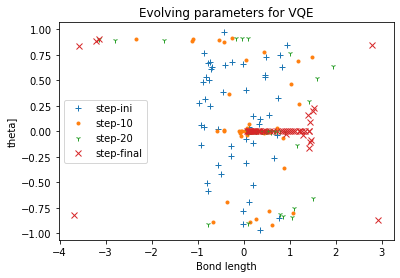

In [72]:
thetas=np.loadtxt("thetas.txt")[:50]
bond_distance=bond_distances
plt.xlabel("Bond length")
plt.ylabel("theta]")
plt.title("Evolving parameters for VQE")
#plt.plot(bond_distance, thetas, "b-",
#         label="true")
plt.plot(theta_history_nosnake[0][:,0], theta_history_nosnake[0][:,1], 
         '+',label="step-ini")
plt.plot(theta_history_nosnake[2][:,0], theta_history_nosnake[2][:,1], 
         '.',label="step-10")
plt.plot(theta_history_nosnake[4][:,0], theta_history_nosnake[4][:,1], 
         '1',label="step-20")
plt.plot(theta_history_nosnake[-1][:,0], theta_history_nosnake[-1][:,1], 
         'x',label="step-final")
plt.legend()
plt.savefig("no_snake_theta12.jpg",dpi=300)
plt.show()

In [21]:
# theta_history_nosnake=training_decoupled(hams,t_steps=100)